In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
import mock
%matplotlib inline

In [4]:
def build_K(X, sigma_y, kernel):
    K = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            K[i, j] = kernel(X[i], X[j])
    K += sigma_y**2 * np.eye(X.shape[0])
    return K

def posterior_predictive(X, y, sigma_y, kernel, X_star):
    K = build_K(X, sigma_y, kernel)
    
    K_star = np.zeros((X.shape[0], X_star.shape[0]))
    for i in range(X.shape[0]):
        for j in range(X_star.shape[0]):
            K_star[i, j] = kernel(X[i], X_star[j])
    
    K_star_star = np.zeros((X_star.shape[0], X_star.shape[0]))
    for i in range(X_star.shape[0]):
        for j in range(X_star.shape[0]): #note: could be made more efficient using K's symmetry
            K_star_star[i, j] = kernel(X_star[i], X_star[j])
    
    posterior_mean = K_star.T @ np.linalg.inv(K) @ f
    posterior_cov = K_star_star - K_star.T @ np.linalg.inv(K) @ K_star
    
    return posterior_mean, posterior_cov

## A few kernels

In [5]:
def sq_exp_kernel(sigma=1, l=1):
    """
    l determines the length of the 'wiggles' in your function. 
    You won't be able to extrapolate more than l units away from your data.
    sigma determines the average distance of your function away from its mean.
    """
    return lambda x1, x2: sigma**2 * np.exp(-np.dot((x1 - x2), (x1 - x2)) / (2 * l**2))

In [6]:
def spectral_kernel(w, mu, v):
    """
    Note q is number of mixture components, p is dimension of input
    
    w - q x 1 vector
    weight of each gaussian mixture component
    
    mu - q x p matrix
    mean of each gaussian mixture component
    
    v - q x p matrix
    variance of each gaussian mixture component
    
    source: http://www.cs.cmu.edu/~andrewgw/typo.pdf
    """
    def kern_func(x1, x2):
        Tau = np.atleast_2d(x1 - x2)
        exp = np.exp(-2 * np.pi**2 * v * (Tau**2).T) #  q x p
        prod = np.prod(exp, axis=1) #  q x 1
        cos = np.cos(2 * np.pi * mu @ Tau) # q x 1
        return np.sum((w * cos).T * prod)
    
    return kern_func

## Test Spectral Kernel

In [7]:
# q_test = 10
# p_test = 2
# w_test = 2 * np.ones((q_test, 1))
# mu_test = np.ones((q_test, p_test))
# v_test = np.ones((q_test, p_test))
# k_test = spectral_kernel(w_test, mu_test, v_test)

# assert k_test(np.ones((p_test, 1)), np.ones((p_test, 1))) == 2 * q_test
# assert np.isclose(k_test(np.zeros((p_test, 1)), .125 * np.ones((p_test, 1))), 0)

## Fit Spectral Kernel

### Partials

$ll(x, k) \propto -\log |k| -  x^T k^{-1} x$

$\frac{\partial ll(x, k)}{\partial k} \propto k^{-1}x x^T k^{-1} - k^{-1}$

$\frac{\partial k}{\partial w_q} = \cos(2\pi \tau^T\mu_q)\prod_p \exp(-2\pi^2\tau_p^2 v_q^{(p)})$

$\frac{\partial k}{\partial \mu_q} = -2\pi\tau w_q \sin(2\pi \tau^T\mu_q)\prod_p \exp(-2\pi^2\tau_p^2 v_q^{(p)})$

$\frac{\partial k}{\partial v_q^{(j)}} = -2\pi^2\tau_j^2 w_q [\cos(2\pi \tau^T\mu_q)]^{(j)}\prod_p \exp(-2\pi^2\tau_p^2 v_q^{(p)})$

### Sources

https://arxiv.org/pdf/1302.4245.pdf

https://github.com/cdipaolo/GPy/blob/daf2fc868e41c5037dac10fbb16b7da2be614106/GPy/kern/src/spectral_mixture.py

http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf

https://stats.stackexchange.com/questions/27436/how-to-take-derivative-of-multivariate-normal-density


In [146]:
def gradf(x, *args):
    """
    x = w, mu, v
    args = X, sigma_y

    """
    w, mu, v = x
    X, sigma_y = args
    
    kernel = spectral_kernel(w, mu, v)
    K = build_K(X, sigma_y, kernel)
    K_inv = np.linalg.inv(K)
    dll_dk = K_inv @ X @ X.T @ K_inv - K_inv


    # inefficient, could be vectorized, used for testing
    n = X.shape[0]
    q = w.shape[0]
    dk_dw = np.zeros_like(w)
    dk_dmu = np.zeros_like(mu)
    dk_dv = np.zeros_like(v)
    for i in range(n):
        for j in range(n):
            Tau = X[i] - X[j] #  p x 1
            
            cos = np.cos(2 * np.pi * mu @ Tau)[:, np.newaxis] # q x 1
            exp = np.exp(-2 * np.pi**2 * v * (Tau**2).T) #  q x p
            prod = np.prod(exp, axis=1)[:, np.newaxis] #  q x 1
            sin =  -2 * np.pi * w * np.sin(2 * np.pi * mu @ Tau)[:, np.newaxis] * Tau.T # q x p
            dk_dw += dll_dk[i, j] * cos * prod
            dk_dmu += dll_dk[i, j] * sin * prod
            dk_dv += dll_dk[i, j] * -2 * np.pi**2 * Tau**2 * w * cos * prod

            
    return dk_dw, dk_dmu, dk_dv

    
def spectral_f(x, *args):
    w, mu, v = x
    X, sigma_y = args 
    
    kernel = spectral_kernel(w, mu, v)
    K = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            K[i, j] = kernel(X[i], X[j])
    K += sigma_y**2 * np.eye(X.shape[0])
    return np.log(np.linalg.det(K)) + X.T @ np.linalg.inv(K) @ X


def optimize_spectral_kernel(w0, mu0, v0, X, sigma_y, epsilon=1e-3, iters=100, verbose=False):
    """    
    w - q x 1 vector
    weight of each gaussian mixture component
    
    mu - q x p matrix
    mean of each gaussian mixture component
    
    v - q x p matrix
    variance of each gaussian mixture component
    
    X - n x p matrix
    data
    
    sigma_y - n x 1 matrix
    variance of each data point, i.e. confidence in each sample
    """
    w, mu, v = w0.copy(), mu0.copy(), v0.copy()
    prev_ll = 0
    for i in range(iters):
        kernel = spectral_kernel(w, mu, v)
        K = build_K(X, sigma_y=0, kernel=kernel)
        K_inv = np.linalg.inv(K)
        ll = (-np.log(np.linalg.det(K)) -X.T @ K_inv @ X)[0, 0]
        if abs(ll - prev_ll) <= 1e-5:
            break
        prev_ll = ll
        if verbose:
            print('Iteration {}: log likelihood: {}'.format(i, ll))
        dw, dmu, dv = gradf((w, mu, v), X, sigma_y)
        w += epsilon * dw
        mu += epsilon * dmu
        v += epsilon * dv
        
    
    return w, mu, v

In [9]:
def plot_GP(X, f, mu_star, sigma_star):
    plt.scatter(X, f, c='red', label='X')
    sigma = sigma_star.diagonal()
    plt.fill_between(X_star, (mu_star - sigma), (mu_star + sigma), alpha=.5, label='sigma')
    plt.plot(X_star, mu_star, label='mu_star')
    plt.legend(loc=3, bbox_to_anchor=(0., 1.02, 1., .102), mode='expand')
    plt.show()

## Test Data

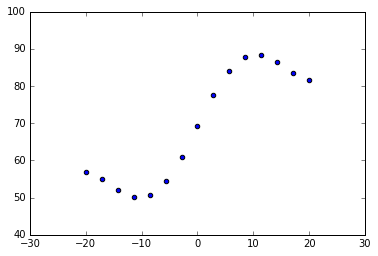

In [177]:
order = 2
X = np.linspace(-20, 20, 15)
# genweights = 10 * np.random.randn(order)
# def poly(i):
#     return (genweights.T @ np.array([i**p for p in range(order)]) 
#             + np.random.normal(0, 10*order**order))
# polyfunc = np.vectorize(poly)
# f = polyfunc(X)
#  
f = X + 10 * np.sin(X / 5) + 5 * stats.norm.rvs(15)
plt.scatter(X, f)

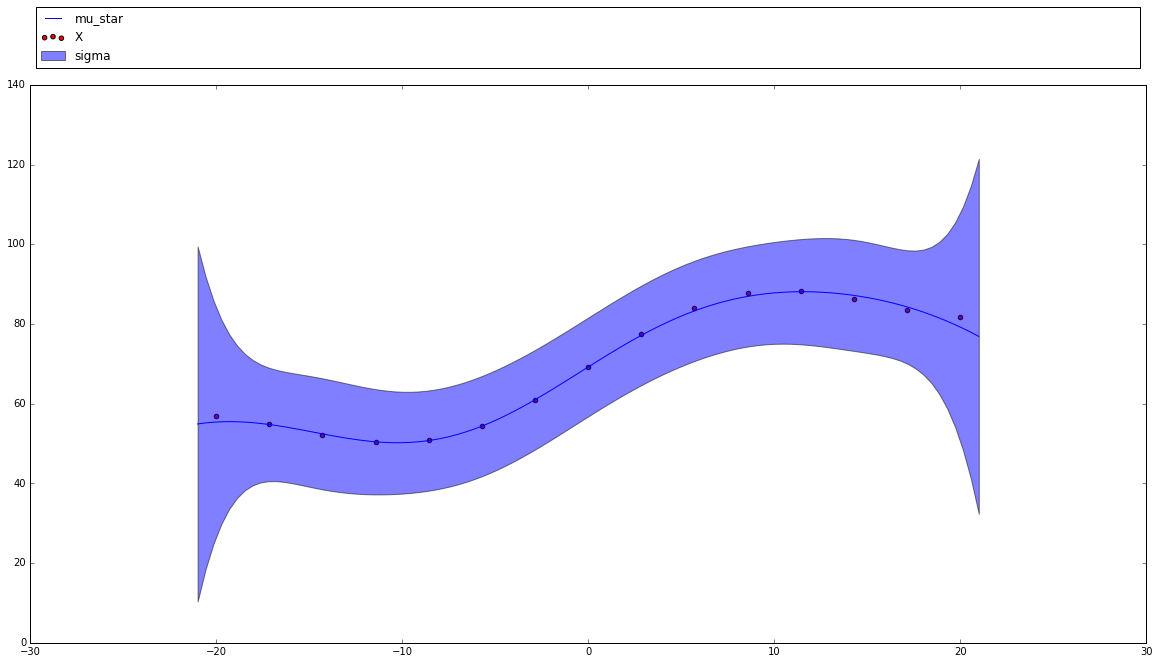

In [178]:
sigma_y = np.ones(15) * np.sqrt(10*order**order)
X_star = np.linspace(-21, 21, 100)
mu_star, sigma_star = posterior_predictive(X, f, sigma_y, sq_exp_kernel(sigma=10*order**order, l=10), X_star)
plt.figure(figsize=(20,10))
plot_GP(X, f, mu_star, sigma_star)

/home/nate/.local/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: covariance is not positive-semidefinite.


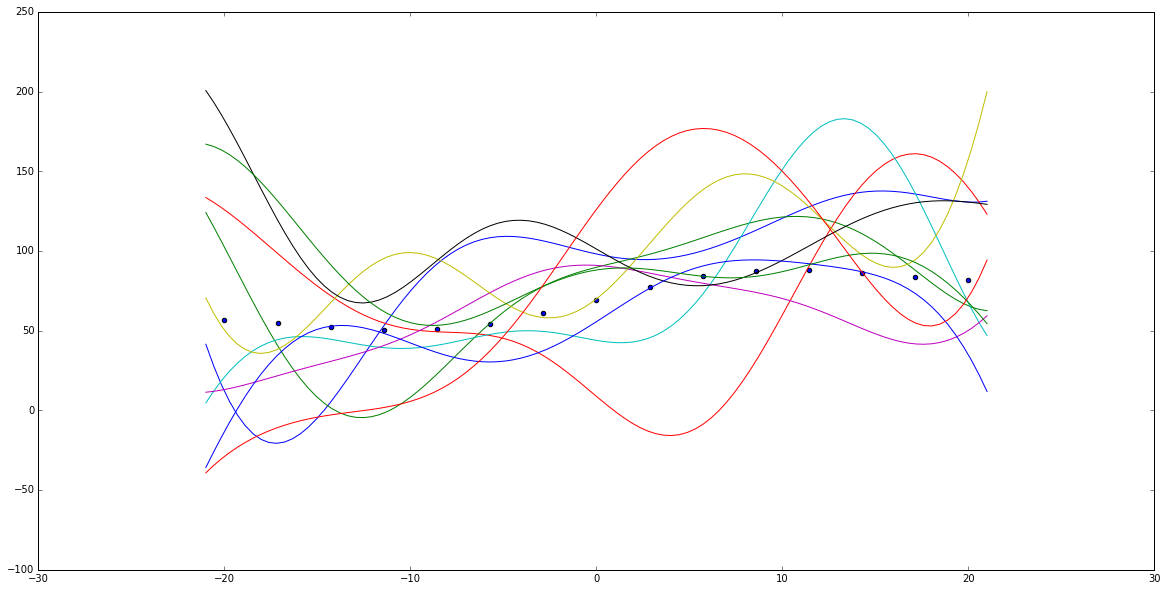

In [179]:
plt.figure(figsize=(20, 10))

# sample from posterior predictive
for i in range(10):
    plt.plot(X_star, np.random.multivariate_normal(mean=mu_star, cov=100*sigma_star))
    
plt.scatter(X, f)
plt.show()

## Test Spectral Kernel Against Conner's

In [180]:
p = 1
q = 1
w = stats.uniform.rvs(size=(q, 1))
w /= w.sum() * 1e-3
mu = np.random.normal(size=(q, p))
v =  1e-4 * stats.gamma(1).rvs(size=(q, p))**-1

X = X.reshape((X.shape[0], 1))
x = (w, mu, v)
args = (X, 0)

dw, dmu, dv = gradf(x, *args)

kernel = spectral_kernel(w, mu, v)
K = build_K(X, sigma_y=0, kernel=kernel)
K_inv = np.linalg.inv(K)
dll_dk = K_inv @ X @ X.T @ K_inv - K_inv

ll = -np.log(np.linalg.det(K)) -X.T @ K_inv @ X
print(ll[0, 0])

-62.7724846059


In [181]:
tau = X[:,np.newaxis,:] - X
K = np.cos(2*np.pi*np.tensordot(tau, mu.T, axes=1)) * \
    np.exp(-2 * np.pi**2 * np.tensordot(tau**2, v.T, axes=1))
dw_conner = (dll_dk[:,:,np.newaxis] * K).sum(axis=(0,1)).reshape(-1,1)

K = (w[:,:,np.newaxis] * (np.sin(2*np.pi*np.tensordot(tau, mu.T, axes=1)) * \
        np.exp(-2 * np.pi**2 * np.tensordot(tau**2, v.T, axes=1))).T).T
dmu_conner = np.einsum(
        'ijk,ijl->kl',
        -2*np.pi*tau,
        dll_dk[:,:,np.newaxis] * K,
    )

K = (w[:,:,np.newaxis] * (np.cos(2*np.pi*np.tensordot(tau, mu.T, axes=1)) * \
        np.exp(-2 * np.pi**2 * np.tensordot(tau**2, v.T, axes=1))).T).T
dv_conner = np.einsum(
        'ijk,ijl->kl',
        -2 * np.pi**2 * tau**2,
        dll_dk[:,:,np.newaxis] * K
    )

In [182]:
assert np.isclose(dv_conner.T, dv).all()
assert np.isclose(dw_conner.T, dw).all()
assert np.isclose(dmu_conner.T, dmu).all()

In [184]:
w1, mu1, v1 = optimize_spectral_kernel(w0=w, mu0=mu, v0=v, X=X, sigma_y=0, verbose=True, epsilon=1e-11, iters=500)

Iteration 0: log likelihood: -62.77248460593436
Iteration 1: log likelihood: -62.708518581603336
Iteration 2: log likelihood: -62.644227069870055
Iteration 3: log likelihood: -62.5796072190826
Iteration 4: log likelihood: -62.51465614777782
Iteration 5: log likelihood: -62.44937093641627
Iteration 6: log likelihood: -62.38374862623105
Iteration 7: log likelihood: -62.31778622783813
Iteration 8: log likelihood: -62.251480707308154
Iteration 9: log likelihood: -62.18482899839612
Iteration 10: log likelihood: -62.117827988194264
Iteration 11: log likelihood: -62.050474533756294
Iteration 12: log likelihood: -61.982765443074655
Iteration 13: log likelihood: -61.91469748920502
Iteration 14: log likelihood: -61.84626739873208
Iteration 15: log likelihood: -61.77747186043515
Iteration 16: log likelihood: -61.70830751663399
Iteration 17: log likelihood: -61.63877096601372
Iteration 18: log likelihood: -61.56885876618345
Iteration 19: log likelihood: -61.498567425815054
Iteration 20: log likeli

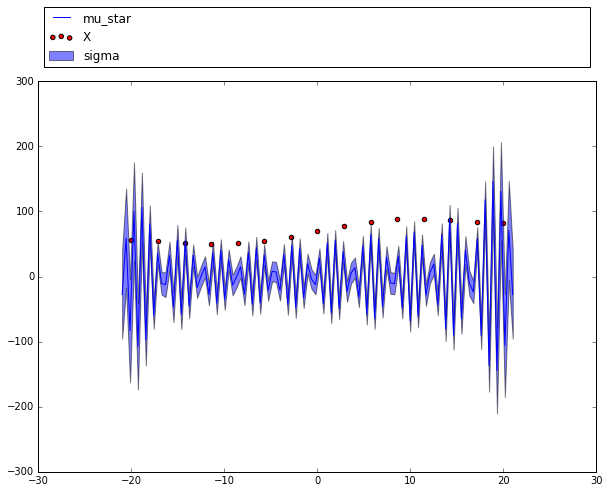

In [190]:
mu_star, sigma_star = posterior_predictive(X, f, sigma_y, spectral_kernel(w1, mu1, v1), X_star)
plt.figure(figsize=(10,7))
plot_GP(X, f, mu_star, sigma_star)